In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class DeepGP:
  def __init__(self, dim, ktype="rbf", nlayers=3, device="cuda" ):
    self.beta = 10.0
    self.dim = dim
    self.device = device
    self.nlayers = nlayers

    if ktype=="rbf":
      self.cov = self.rbf_cov
    elif ktype=="deep":
      self.cov = self.deep_cov
    else:
      raise ValueError("ktype must be 'rbf' or 'deep'")

  def k(self, xi, xj):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 

  def rbf_cov(self, xi, xj ):
    a = xi.view(-1,1,self.dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.dim).repeat(len(xi), 1, 1)
    return self.k(a,b)

  def deep_k(self, x1, x2, l, dim):
    sig_b = 1.0
    sig_w = 5.0
    if l>0:
      k1= self.deep_k(x1, x1, l-1, dim)
      k2= self.deep_k(x2, x2, l-1, dim)
      theta=torch.acos( self.deep_k(x1, x2, l-1, dim) / torch.sqrt(k1 * k2 + 0.0001))
      return sig_b + (sig_w/(2*np.pi))*torch.sqrt(k1*k2)*(torch.sin(theta) + (np.pi - theta)*torch.cos(theta))
    else:
      return sig_b + sig_w*( torch.sum(x1*x2, 2) / (torch.norm(x1, dim=2) * torch.norm(x2, dim=2))  )
      #return sig_b + sig_w*( self.k(x1, x2) )

  def deep_cov(self, xi, xj ):
    a = xi.view(-1,1, self.dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1, self.dim).repeat(len(xi), 1, 1)
    return self.deep_k(a, b, self.nlayers, self.dim)

  def learn(self, xt, yt ):
    self.xt = torch.tensor(xt, device=self.device).reshape(-1,self.dim)
    self.yt = torch.tensor(yt, device=self.device)
    N = len(xt)

    # カーネル行列を定義
    self.K = self.cov( self.xt, self.xt ) + torch.eye(N, N, device=self.device)/self.beta
    self.K_inv = torch.inverse( self.K )
  
  def predict( self, x ):
    x = torch.tensor(x, device=self.device).reshape(-1,self.dim)

    kx = self.cov( x, self.xt )
    k = self.cov(x, x) + 1.0/self.beta

    mu = torch.mm( torch.mm( kx, self.K_inv ), self.yt.reshape(-1,1) )
    sig = k - torch.mm( kx, torch.mm(self.K_inv, torch.t(kx)) )
        
    return mu.detach().cpu().numpy().flatten(), sig.diag().detach().cpu().numpy().flatten()

# データ生成
縦長の矩形なら1，それ以外は0

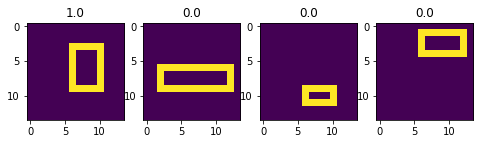

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def make_rectangle(arr, x0, y0, x1, y1):
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0 : x1 + 1] = 1


def make_random_rectangle(arr):
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1


def make_rectangles_dataset(num, w, h):
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return (d.reshape(num, w * h), Y)

X, Y = data = make_rectangles_dataset(100, 14, 14)
Xt, Yt = test_data = make_rectangles_dataset(100, 14, 14)

plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(14,14))
    plt.title(Y[i, 0])

# 評価

In [10]:
gp = DeepGP(196, "rbf", 0, "cuda")

gp.learn( X.reshape((-1,196)), Y )
mu, sig = gp.predict(Xt)
acc = np.sum((mu>0.5)==Yt.flatten())/Yt.shape[0]
print("RBF Kernel Acc:", acc)

gp = DeepGP(196, "deep", 3, "cuda")
gp.learn( X.reshape((-1,196)), Y )

mu, sig = gp.predict(Xt)
acc = np.sum((mu>0.5)==Yt.flatten())/Yt.shape[0]
print("Deep Kernel Acc:", acc)

RBF Kernel Acc: 0.58
Deep Kernel Acc: 0.79
